# Calibration of a lens

## Preprocessing of a dotted grid

In [1]:
%matplotlib widget
from matplotlib.pyplot import subplots

In [109]:
import numpy
from PIL import Image
from silx.math.medianfilter import medfilt2d
from pyFAI.ext.watershed import InverseWatershed, Bilinear
from scipy.ndimage import convolve

In [3]:
raw = numpy.asarray(Image.open("test2.jpg").convert("L")).astype("int16")

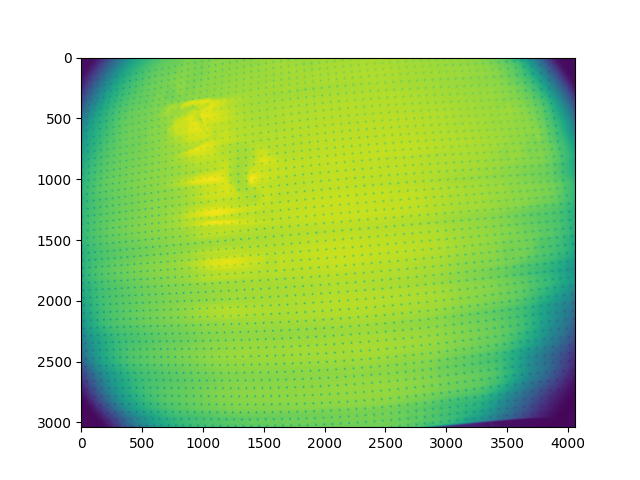

In [4]:
fig,ax = subplots()
ax.imshow(raw)

In [8]:
flat = medfilt2d(raw, 51, False, "reflect")

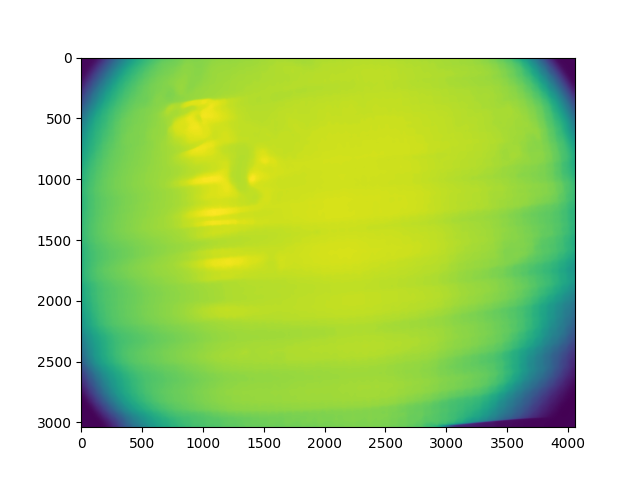

In [9]:
fig, ax = subplots()
ax.imshow(flat)

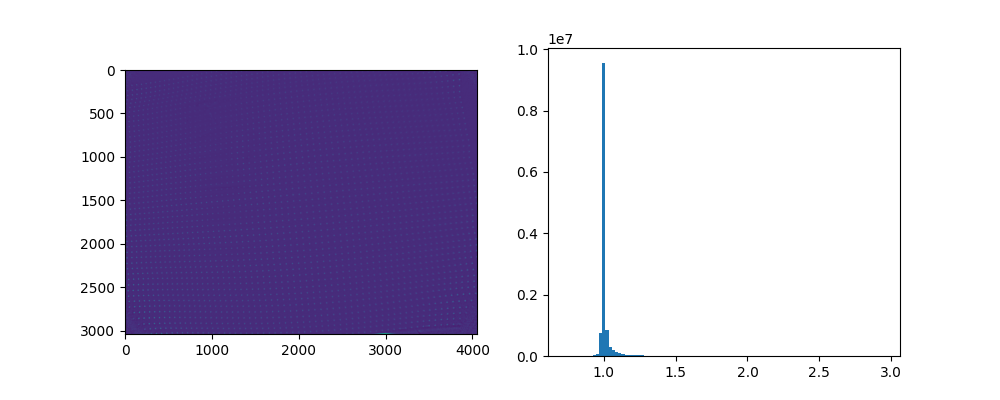

In [41]:
norm = flat/raw
fig, ax = subplots(1, 2, figsize=(10, 4))
ax[0].imshow(norm)
_=ax[1].hist(norm.ravel(), 100)

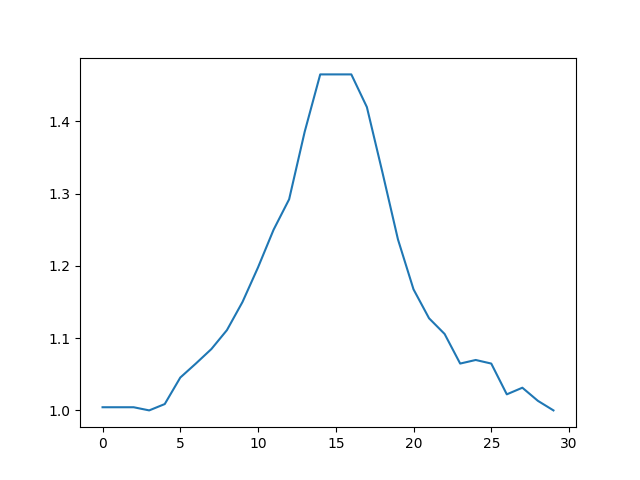

In [62]:

#Look at the profile of the peak to measure the width (it is expected to be a crenel)
fig,ax = subplots()
ax.plot(norm[1723,2010:2040])
pass



Integral of the kernel:  105.33906747977825


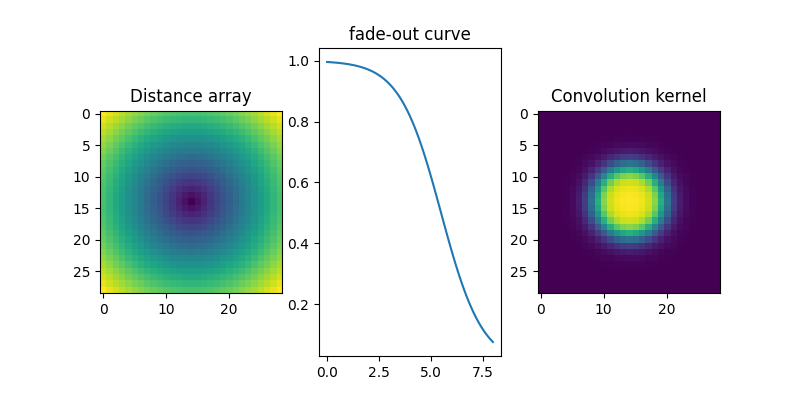

In [64]:
#Definition of the convolution kernel
ksize = 29
y,x = numpy.ogrid[-(ksize-1)//2:ksize//2+1,-(ksize-1)//2:ksize//2+1]
d = numpy.sqrt(y*y+x*x)

#Fade out curve definition
fadeout = lambda x: 1/(1+numpy.exp(1*(x-5.5)))

kernel = fadeout(d)
mini=kernel.sum()
print("Integral of the kernel: ", mini)

fig,ax = subplots(1,3, figsize=(8,4))
ax[0].imshow(d)
ax[0].set_title("Distance array")

ax[1].plot(numpy.linspace(0,8,100),fadeout(numpy.linspace(0,8,100)))
ax[1].set_title("fade-out curve")

ax[2].imshow(kernel)
ax[2].set_title("Convolution kernel")
pass



NameError: name 'normalized' is not defined

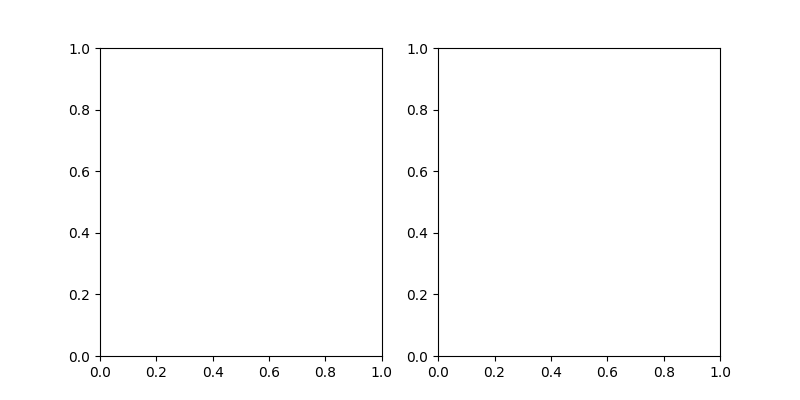

In [67]:
smooth = convolve(norm, kernel, mode="constant", cval=1)/mini

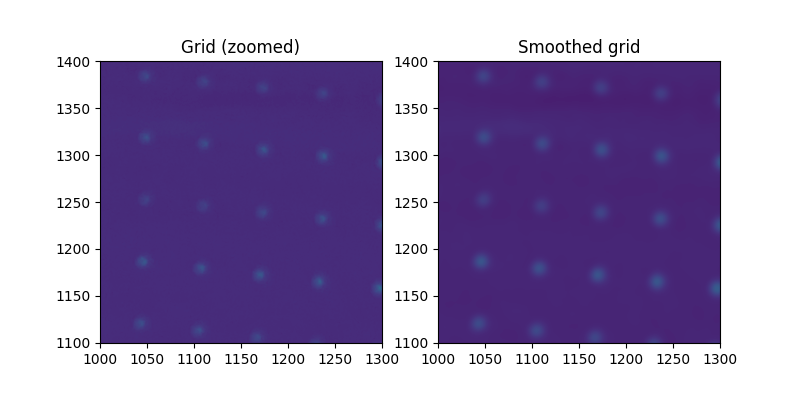

In [68]:
fig,ax = subplots(1,2, figsize=(8,4))
ax[0].imshow(norm)
ax[0].set_ylim(1100,1400)
ax[0].set_xlim(1000,1300)
ax[1].imshow(smooth)
ax[1].set_ylim(1100,1400)
ax[1].set_xlim(1000,1300)

ax[0].set_title("Grid (zoomed)")
ax[1].set_title("Smoothed grid")
pass


In [69]:
ws = InverseWatershed(smooth)
ws.init()

In [70]:
print(len(ws.regions))

21416


In [71]:
ws.merge_singleton()

In [72]:
len(ws.regions)

21416

In [73]:
ws.merge_twins()

In [74]:
len(ws.regions)

21416

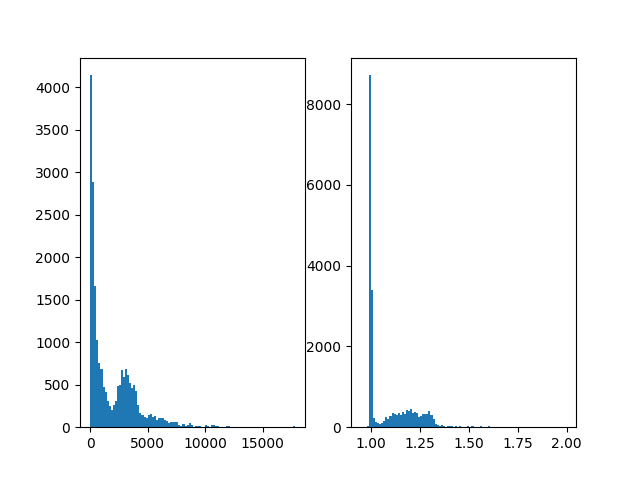

In [97]:
fig,ax = subplots(1, 2)
_=ax[0].hist([r.size for r in ws.regions.values()], 100)
_=ax[1].hist([r.maxi for r in ws.regions.values()], 100)
#large [r for r in ws.regions.values() if r.size>40]

In [101]:
regions = [r for r in ws.regions.values() if r.size>1000 and r.maxi>1.05]
len(regions)

8661

In [105]:
yx = numpy.array([(i.index//raw.shape[-1],i.index%raw.shape[-1]) for i in regions])

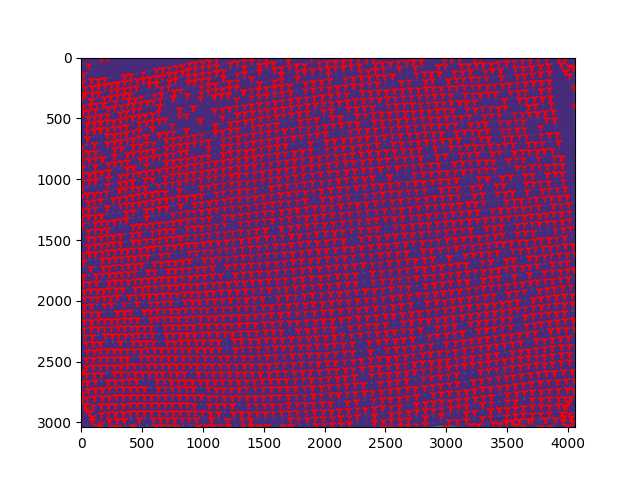

In [107]:
fig, ax = subplots()
ax.imshow(norm)
ax.plot(yx[:,1], yx[:,0], "1r")

In [113]:
#Use a bilinear interpolator to localize/refine the maxima
bl = Bilinear(smooth)
ref_peaks = numpy.array([bl.local_maxi(p) for p in yx])
ax.plot(ref_peaks[:,1], ref_peaks[:,0], "2g")

In [123]:

def _select_roi(mat, ratio):
    """
    Select ROI around the middle of an image.
    
    Parameters
    ----------
    mat : array_like
        2D array.
    ratio : float
        Ratio between the ROI size and the image size.
    
    Returns
    -------
    array_like
        2D array.
    """
    np = numpy
    (height, width) = mat.shape
    ratio = np.clip(ratio, 0.05, 1.0)
    depad_hei = np.int16((height - ratio * height) / 2)
    depad_wid = np.int16((width - ratio * width) / 2)
    mat = mat[depad_hei:height - depad_hei, depad_wid:width - depad_wid]
    return mat

def calc_hor_slope(mat, ratio=0.3):
    """
    Calculate the slope of horizontal lines against the horizontal axis.
    
    Parameters
    ----------
    mat : array_like
        2D array.
    ratio : float
        Used to select the ROI around the middle of an image.
    
    Returns
    -------
    float
        Horizontal slope of the grid.
    """
    np = numpy
    from skimage.segmentation import clear_border
    from skimage.transform import radon
    from scipy import ndimage as ndi
    from scipy.ndimage import center_of_mass
    coarse_range = 30.0  # Degree
    radi = np.pi / 180.0
    mat = np.int16(clear_border(_select_roi(mat, ratio)))
    (height, width) = mat.shape
    list_angle = 90.0 + np.arange(-coarse_range, coarse_range + 1.0)
    projections = radon(np.float32(mat), theta=list_angle, circle=False)
    list_max = np.amax(projections, axis=0)
    best_angle = -(list_angle[np.argmax(list_max)] - 90.0)
    dist_error = 0.5 * width * (np.tan(radi) / np.cos(best_angle * radi))
    mat_label, num_dots = ndi.label(mat)
    list_index = np.arange(1, num_dots + 1)
    list_cent = np.asarray(
        center_of_mass(mat, labels=mat_label, index=list_index))
    list_cent = - list_cent  # For coordinate consistency
    mean_x = np.mean(list_cent[:, 1])
    mean_y = np.mean(list_cent[:, 0])
    index_mid_dot = np.argsort(np.sqrt((mean_x - list_cent[:, 1]) ** 2
                                       + (mean_y - list_cent[:, 0]) ** 2))[0]
    used_dot = list_cent[index_mid_dot]
    line_slope = np.tan(best_angle * radi)
    list_tmp = np.sqrt(
        np.ones(num_dots, dtype=np.float32) * line_slope ** 2 + 1.0)
    list_tmp2 = used_dot[0] * np.ones(num_dots, dtype=np.float32) \
                - line_slope * used_dot[1]
    list_dist = np.abs(
        line_slope * list_cent[:, 1] - list_cent[:, 0] + list_tmp2) / list_tmp
    dots_selected = np.asarray(
        [dot for i, dot in enumerate(list_cent) if list_dist[i] < dist_error])
    if len(dots_selected) > 1:
        (slope, _) = np.polyfit(dots_selected[:, 1], dots_selected[:, 0], 1)
    else:
        slope = line_slope
    return slope

numpy.rad2deg(calc_hor_slope(smooth>1.05, ratio=0.3))

-4.834530258821241